# Import libraries and install packages pydrive and ngrok

In [0]:
! pip install pydrive

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product
from keras.callbacks import TensorBoard


Using TensorFlow backend.


# Define functions

In [7]:
def copy_directory(source_id, local_target):
  try:
    os.makedirs(local_target)
  except: 
    pass
  k = 0
  print('folder id: %s' % (source_id))
  print('downloading to: %s' % (local_target)) 
  file_list = drive.ListFile(
    {'q': "'{source_id}' in parents".format(source_id=source_id)}).GetList()
  for f in file_list:
    if f["title"].startswith("."):
      continue
    fname = os.path.join(local_target, f['title'])
    if f['mimeType'] == 'application/vnd.google-apps.folder':
      copy_directory(f['id'], fname)
    else:
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      k += 1
  print('downloaded files: {}'.format(k))

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(40,40)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        #shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        #shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

# Connect to Google Drive and load files to local drive

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
training_path = os.path.expanduser('~/data/Training')
testing_path = os.path.expanduser('~/data/Testing')
prediction_path = os.path.expanduser('~/data/Prediction')
try:
  os.makedirs(training_path)
  os.makedirs(testing_path)
  os.makedirs(prediction_path)  
except: pass

In [0]:
copy_directory('1aM5XbStClMulA5CShCD9tfkYqAUjCCpX','~/data/Training')  

In [0]:
copy_directory('1PVPjRT22MRPHkiyqCdEeKp3OGiaSUk_C','~/data/Testing')  

In [0]:
copy_directory('1t7xxFxNW_O2WRYMsVKcxrQ6vYBIMd5yG','~/data/Prediction')  

# Prepare training, validation and test dataset

In [0]:
split_dataset_into_test_and_train_sets('~/data/Training','~/data/Training_part','~/data/Validation_part',0.4)

In [210]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
training_set = train_datagen.flow_from_directory('~/data/Training_part', target_size=(64, 64), batch_size=1, class_mode='categorical')
validation_set = train_datagen.flow_from_directory('~/data/Validation_part', target_size=(64, 64), batch_size=1, class_mode='categorical')
test_set = test_datagen.flow_from_directory('~/data/Testing', target_size=(64, 64), batch_size=1, shuffle = False, class_mode='categorical')

Found 2755 images belonging to 62 classes.
Found 1820 images belonging to 62 classes.
Found 2529 images belonging to 62 classes.


# Calculate histograms of datasets

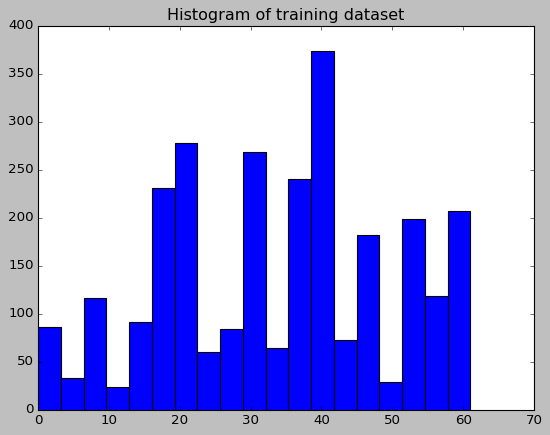

In [212]:
import matplotlib.pyplot as plt
plt.hist(training_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of training dataset")
plt.show()

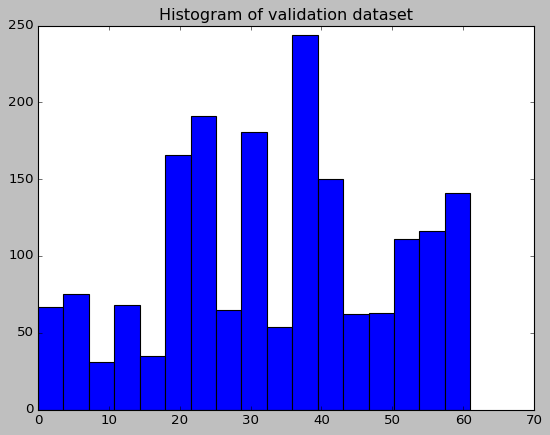

In [213]:
import matplotlib.pyplot as plt
plt.hist(validation_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of validation dataset")
plt.show()

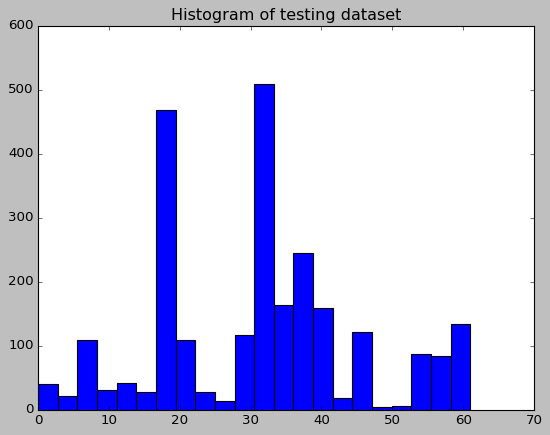

In [214]:
import matplotlib.pyplot as plt
plt.hist(test_set.classes, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of testing dataset")
plt.show()

# Build and train CNN model and connect to TensorBoard, then save model to Google Drive

In [0]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten(input_shape=classifier.output_shape[1:]))
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 62, activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [216]:
classifier.summary()
classifier.get_config()
classifier.layers[0].get_config()
classifier.layers[0].input_shape			
classifier.layers[0].output_shape			
classifier.layers[0].get_weights()
np.shape(classifier.layers[0].get_weights()[0])
classifier.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               1605888   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
__________

True

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=1,
                         write_images=True)

In [0]:
num_epoch = 15

In [234]:
hist = classifier.fit_generator(training_set,steps_per_epoch = 2755, epochs = num_epoch, validation_data = test_set, validation_steps = 1820,callbacks=[tbCallBack])
classifier.save('my_classifier_final_1.h5')

Epoch 1/15
2755/2755 [==============================] - 46s 17ms/step - loss: 0.3567 - acc: 0.8958 - val_loss: 0.2090 - val_acc: 0.9500
Epoch 2/15
 613/2755 [=====>........................] - ETA: 28s - loss: 0.3017 - acc: 0.9054

2755/2755 [==============================] - 44s 16ms/step - loss: 0.2805 - acc: 0.9158 - val_loss: 0.2301 - val_acc: 0.9451
Epoch 3/15
1063/2755 [==========>...................] - ETA: 22s - loss: 0.2261 - acc: 0.9257

2755/2755 [==============================] - 44s 16ms/step - loss: 0.2492 - acc: 0.9289 - val_loss: 0.2336 - val_acc: 0.9522
Epoch 4/15
1171/2755 [===========>..................] - ETA: 22s - loss: 0.2957 - acc: 0.9180

2755/2755 [==============================] - 48s 17ms/step - loss: 0.3113 - acc: 0.9165 - val_loss: 0.2454 - val_acc: 0.9412
Epoch 5/15
1140/2755 [===========>..................] - ETA: 24s - loss: 0.2441 - acc: 0.9246

2755/2755 [==============================] - 50s 18ms/step - loss: 0.2554 - acc: 0.9230 - val_loss: 0.2725 - val_acc: 0.9440
Epoch 6/15
1177/2755 [===========>..................] - ETA: 22s - loss: 0.2405 - acc: 0.9363

2755/2755 [==============================] - 47s 17ms/step - loss: 0.2877 - acc: 0.9205 - val_loss: 0.2227 - val_acc: 0.9566
Epoch 7/15
1230/2755 [============>.................] - ETA: 21s - loss: 0.1818 - acc: 0.9431

2755/2755 [==============================] - 47s 17ms/step - loss: 0.2196 - acc: 0.9347 - val_loss: 0.2671 - val_acc: 0.9549
Epoch 8/15
1261/2755 [============>.................] - ETA: 20s - loss: 0.2207 - acc: 0.9461

2755/2755 [==============================] - 46s 17ms/step - loss: 0.2164 - acc: 0.9452 - val_loss: 0.4685 - val_acc: 0.9027
Epoch 9/15
1258/2755 [============>.................] - ETA: 21s - loss: 0.2703 - acc: 0.9293

2755/2755 [==============================] - 47s 17ms/step - loss: 0.2365 - acc: 0.9343 - val_loss: 0.3513 - val_acc: 0.9154
Epoch 10/15
1186/2755 [===========>..................] - ETA: 23s - loss: 0.2582 - acc: 0.9283

2755/2755 [==============================] - 47s 17ms/step - loss: 0.2047 - acc: 0.9408 - val_loss: 0.2638 - val_acc: 0.9527
Epoch 11/15
1171/2755 [===========>..................] - ETA: 22s - loss: 0.2278 - acc: 0.9368

2755/2755 [==============================] - 52s 19ms/step - loss: 0.2512 - acc: 0.9387 - val_loss: 0.4322 - val_acc: 0.9154
Epoch 12/15
 943/2755 [=========>....................] - ETA: 31s - loss: 0.1969 - acc: 0.9491

2755/2755 [==============================] - 58s 21ms/step - loss: 0.2072 - acc: 0.9445 - val_loss: 0.2707 - val_acc: 0.9505
Epoch 13/15
 865/2755 [========>.....................] - ETA: 29s - loss: 0.2072 - acc: 0.9480

2755/2755 [==============================] - 53s 19ms/step - loss: 0.2171 - acc: 0.9394 - val_loss: 0.2136 - val_acc: 0.9538
Epoch 14/15
1002/2755 [=========>....................] - ETA: 25s - loss: 0.2057 - acc: 0.9461

2755/2755 [==============================] - 47s 17ms/step - loss: 0.1970 - acc: 0.9488 - val_loss: 0.2367 - val_acc: 0.9588
Epoch 15/15
1158/2755 [===========>..................] - ETA: 22s - loss: 0.2681 - acc: 0.9361

2755/2755 [==============================] - 46s 17ms/step - loss: 0.2283 - acc: 0.9463 - val_loss: 0.2267 - val_acc: 0.9560


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile()
uploaded.SetContentFile('my_classifier_final_1.h5')
uploaded.Upload()

# Calculate basic statistics and evaluate the model

In [0]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

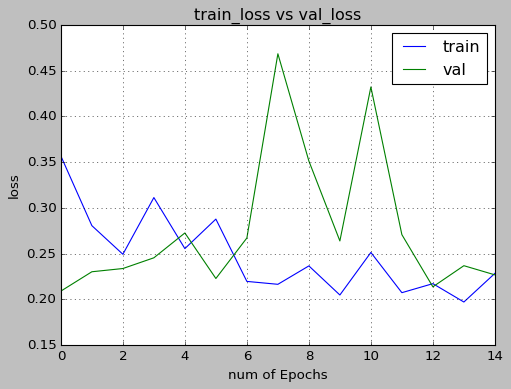

In [237]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

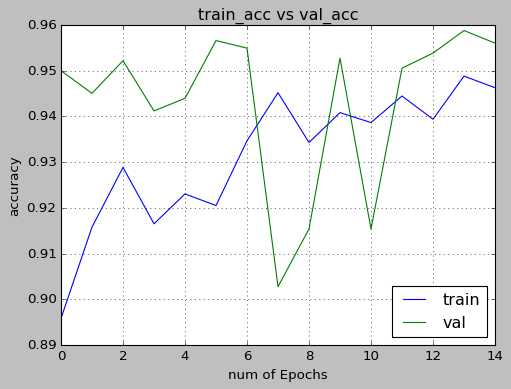

In [238]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [239]:
# Evaluating the model
score = classifier.evaluate_generator(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.27306443147095355
Test accuracy: 0.9462238038750495


In [0]:
model = load_model('my_classifier_final_1.h5')

# Predict by single image input

In [0]:
labels = ["Uneven road", "Speed bump", "Slippery road", "Dangerous curve to the left", "Dangerous curve to the right", "Double dangerous curve to the left", "Double dangerous curve to the right", "Presence of children", "Bicycle crossing", "Cattle crossing", "Road works ahead", "Traffic signals ahead", "Guarded railroad crossing", "Indefinite danger", "Road narrows", "Road narrows from the left", "Road narrows from the right", "Priority at the next intersection", "Intersection where the priority from the right is applicable", "Yield right of way", "Yield to oncoming traffic", "Stop", "No entry for all drivers", "No bicycles allowed", "Maximum weights allowed (including load)", "No cargo vehicles allowed", "Maximum width allowed", "Maximum height allowed", "No traffic allowed in both directions", "No left turn", "No right turn", "No passing to the left vehicles having more than 2 wheels and horse drawn vehicles", "Maximum speed limit", "Mandatory way for pedestrians and bicycles", "Mandatory direction (straight on)", "Mandatory direction (to the right or to the left)", "Mandatory directions(straight on and to the right)", "Mandatory traffic circle", "Mandatory bicycle path", "Path shared between pedestrians, bicycles and mopeds class A", "No parking", "No waiting or parking", "No parking from the 1 st to the 15th of the month", "No parking from the 16th till the end of the month", "Priority over oncoming traffic", "Parking allowed", "Additional parking sign for handicap only", "Parking exclusively for motorcars", "Parking exclusively for trucks", "Parking exclusively for buses/coaches", "Parking on sidewalk or verge mandatory", "Beginning of a residential area", "End of a residential area", "One way traffic", "Dead end", "End of road works", "Pedestrian crosswalk", "Bicycles and mopeds crossing", "Parking ahead", "Speed bump", "End of priority road", "Priority road"]

In [242]:
test_image = image.load_img('~/data/Prediction/00017_00002.ppm', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
y_pred = np.argmax(result , axis=-1)
print(labels[int(y_pred)])

Uneven road


# Calculate and show confusion matrix

Normalized confusion matrix
[[0.5        0.5        0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.85714286 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.82352941 0.         0.        ]
 [0.         0.         0.         ... 0.         0.36363636 0.63636364]
 [0.         0.         0.         ... 0.         0.         0.99047619]]


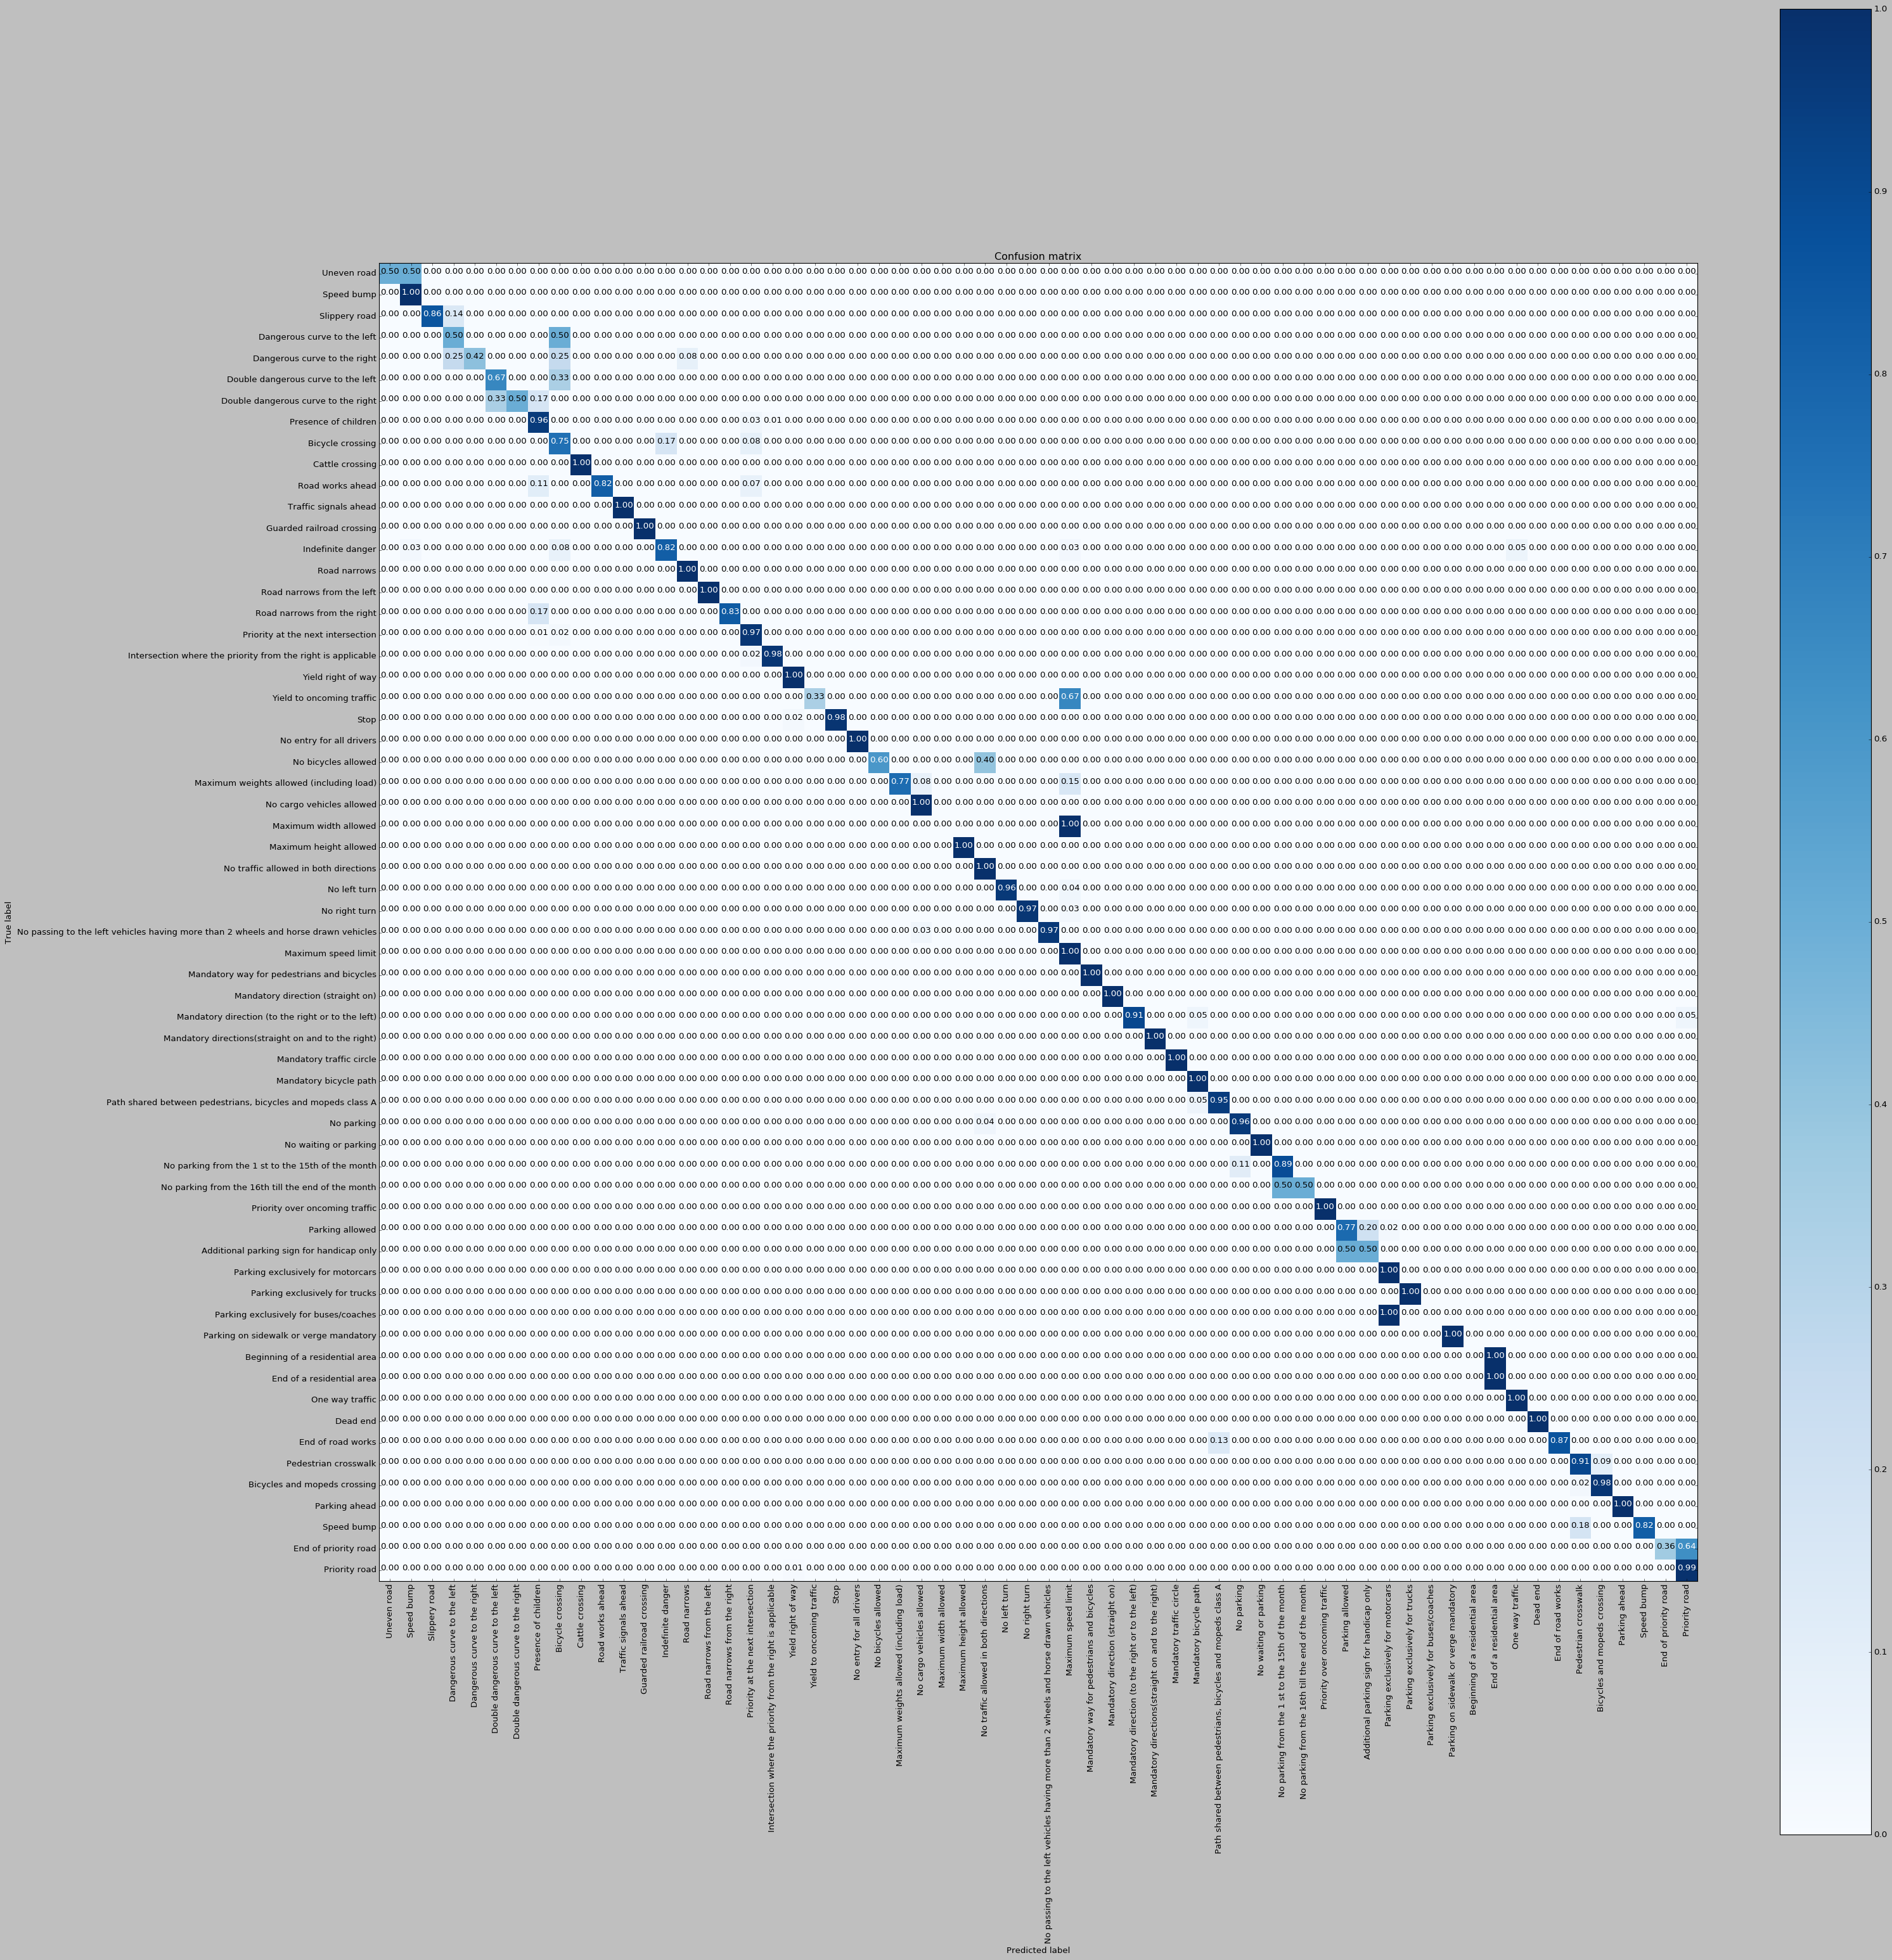

In [245]:
test_set.reset()
probabilities  = model.predict_generator(test_set)
y_pred = np.argmax(probabilities , axis=-1)

cnf_matrix = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cnf_matrix, labels, True)